# ***Toxic Comment Classification* 🤬**
### By : ***Better Than Machine*** 💻

In this project , we aim to build a classification project capable of detecting various toxic comments in social media that are abusive and insulting.The main idea of the model is to identify the toxicity in online conversations where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. Identify toxic comments can lead communities to facilitate and improve online conversations and exchange of opinions. Cyberbullying is one of the major societal problem.

**Steps of the Project**
---
---
It is an end-to-end project covering all the necessary steps from text preprocessing to final classification and tuning.

---


1.   **Preprocessing Text**
  * Importing Data and Cleaning
  * Tokenization and stopwords removal
  * Stemming 
2.   **Embeddings in NLP**
  * Splitting the data in Training and Testing sets
  * Different Embeddings : TF-IDF , Word2Vec 
  * Oversampling SMOTE for Dealing with Imbalanced Classes
  * Normalization
3.   **Model Selection and Hyperparameter Tuning**
  * LinearSvc
  * Logistic Regression
  * Naive Bayes
  * RandomForest 
  * AdaBoost
4.   **Evaluation and Threshold Tuning**
  * ROC , AUC , Precision-Recall Curve
  * Threshold Tuning

5.   **Post Analysis**
  * Analysis of Various Steps and thier impact on result
  * Summary

## **DATASET**
The dataset for this project is hosted on Kaggle and was part of a competition. According to the description on Kaggle, The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. 
I will use only the train set provided by Kaggle and i will proceed with the usual splitting into train and test sets. The dataset consists of 143346 non-toxic comments and 16225 toxic comments. Binary Classification : A comment is considered toxic if belongs to at least one of the toxicity categories provided in the original dataset. The original toxicity labels have been assigned in a manual way by humans, according to the description of the dataset available on Kaggle.
The dataset contains the raw comments, extracted as they were originally posted by users. This comments have been extracted from Wikipedia talks pages. For more details about the dataset, please refer to the competition page on Kaggle, at
 
*https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge*

In [11]:
# UTILITY
import pandas as pd
import numpy as np
from joblib import dump
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, Normalizer
import warnings

# IMBALANCED LEARN
## OverSampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
## UnderSampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
## Mixture
from imblearn.combine import SMOTEENN


# NLP
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
import spacy
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer

# MODELS
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# EVALUATION
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,\
     f1_score, roc_auc_score, roc_curve, precision_recall_curve

# VISUALIZATION
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# INIT
warnings.filterwarnings('ignore')
NUM_OF_THREADS = 10 # set > 1 to use multithreading support

In [12]:
# read data from csv file
data = pd.read_csv("data/train.csv")
# drop na and reset index
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
# column name to work with
name = "comment_text"

In [13]:
# function to clean the text performin some simple regex pattern matching
def apply_regex(corpus):
    corpus = corpus.apply(lambda x: re.sub("\S*\d\S*"," ", x))          # removes numbers and words concatenated with numbers (IE h4ck3r)
    corpus = corpus.apply(lambda x: re.sub("\S*@\S*\s?"," ", x))        # removes emails and mentions (words with @)
    corpus = corpus.apply(lambda x: re.sub(r'http\S+', ' ', x))         # removes URLs
    corpus = corpus.apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ',x))    # keeps numbers and letters
    corpus = corpus.apply(lambda x: x.replace(u'\ufffd', '8'))          # replaces the ASCII '�' symbol with '8'
    corpus = corpus.apply(lambda x: re.sub(' +', ' ', x))               # removes multiple spaces
    return corpus
# apply the function and clean the data
data[name] = apply_regex(data[name])

In [14]:
# ASSIGN A BINARY LABEL -- 1 is toxic, 0 is not
data["label"] = np.where(data["toxic"]==1, 1, 
                np.where(data["severe_toxic"]==1, 1, 
                np.where(data["obscene"]==1, 1, 
                np.where(data["threat"]==1, 1,
                np.where(data["insult"]==1, 1,
                np.where(data["identity_hate"]==1, 1, 0))))))
Counter(data["label"])

Counter({0: 143346, 1: 16225})

## 3. Preprocessing Text - NLP pipeline

In [15]:
# TOKENIZE TEXT - we use the Spacy library stopwords
spacy_model = spacy.load("en_core_web_sm")
stop_words = spacy_model.Defaults.stop_words

In [16]:
# TOKENIZE TEXT and STOP WORDS REMOVAL - execution (removes also the words shorter than 2 and longer than 15 chars)
import nltk
nltk.download('punkt')
def tokenize(doc):
    tokens_1 = word_tokenize(str(doc))
    return [word.lower() for word in tokens_1 if len(word) > 1 and len(word) < 15 and word not in stop_words and not word.isdigit()]
    
data["tokenized"] = data[name].apply(tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lokeshnahar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# STEMMING
stemmer = SnowballStemmer(language="english")

def applyStemming(listOfTokens):
    return [stemmer.stem(token) for token in listOfTokens]

data['stemmed'] = data['tokenized'].apply(applyStemming)

**The final result** of the NLP preprocessing is shown in the next cell. **We can see the result of all the steps**, from raw text to stemmed text. For the next steps, **we will use the stemmed text.**

In [18]:
data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label,tokenized,stemmed
27894,49d4fa7fd8d816a3,June UTC I am greatful that you saw my humoro...,0,0,0,0,0,0,0,"[june, utc, greatful, saw, humorous, intent, b...","[june, utc, great, saw, humor, intent, but, se..."
108347,4335d6e2f4688ec8,AFAQ is published on the internet AFAQ is not...,0,0,0,0,0,0,0,"[afaq, published, internet, afaq, secondary, s...","[afaq, publish, internet, afaq, secondari, sourc]"
126235,a32be1b37dd9d89e,Wierd The even indexed Euler numbers except ar...,0,0,0,0,0,0,0,"[wierd, the, indexed, euler, numbers, zero, so...","[wierd, the, index, euler, number, zero, some,..."
107735,3fe7e64d60ca7f2a,The last thing I was trying to do was make you...,0,0,0,0,0,0,0,"[the, thing, trying, feel, stupid, unintellige...","[the, thing, tri, feel, stupid, unintellig, ch..."
135484,d49f6854329089c1,REDIRECT Talk Syrtis Major Planum,0,0,0,0,0,0,0,"[redirect, talk, syrtis, major, planum]","[redirect, talk, syrti, major, planum]"


## 5. Splitting the Data in Training and Testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data["stemmed"], data["label"], random_state=42)

## 6. Different Embeddings: TF-IDF, Word2Vec

### TF-IDF Vectorizer

**Term Frequency–Inverse Document Frequency** (TF-IDF) is a popular technique used to **compute words importance across all the documents** in the corpus. In particular, the assumption is that a word that appears more times in a document but doesn't appear in all the others, is important for that document. TF-IDF **assigns a weight to each word based on the occurence frequency**. At the end, words that are frequent in general will have a lower weight (carry less information for a specific document).

We represents a set of words (for example a comment) with an **array containing the scores of the words**.

This methods belongs to the "Bag of Words" category and share **some disadvantages** in respect to more advance methods. For instance, **word order is lost and the context is not considered**.

The stemmed text is passed to the sklearn *TfidfVectorizer* specifying a number of features equal to 500. This is an arbitrary choice, and in order to have a fair comparison with other method, this parameter will be setted to 500 for all the three methods.

In [20]:
# encoding text into vectors
# since already tokenized
def identity_tokenizer(text):
  return text
tfid = TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer, max_features=80)

train_vectors_tfidf = tfid.fit_transform(X_train).toarray()
test_vectors_tfidf = tfid.transform(X_test).toarray()

### Word2Vec: Model Creation and Persistence Store

We start by setting the parameter for the train of the model. Once ther model is trained, we save it on the disk.

In [25]:
w2v = Word2Vec(
                sg=0,                   # 1 for skip-gram, 0 for CBOW
                vector_size=500,        # size of the resulting vector
                workers=NUM_OF_THREADS, # multithreading
                seed=42                 # seed for reproducibility
            )            

# building the vocabulary and training the model
w2v.build_vocab(X_train, progress_per=50000)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=30, report_delay=1)
# saving the model to the disk in order to avoid training again
w2v.save("w2vec.model")
print("Model Made Successfully")

Model Made Successfully


#### Word2Vec Embedding using the Trained Model

In [26]:
wordVec = Word2Vec.load("./w2vec.model").wv

The following function takes the tokens of each document (comment) and look up in the model for the vectorial representation of each token. All the representations of the tokens of each document are averaged together in order to get a vectorial representation of the whole comment. **Basically a comment is represented as the average of the words representations of the words that make that comment.**

In [27]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(corpus, w2v_model):
    DIMENSION = 500
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in corpus:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


train_vectors_w2v = embedding_feats(X_train, wordVec)
test_vectors_w2v = embedding_feats(X_test, wordVec)

## 7. Dealing with Imbalanced Classes

In [28]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

##### TFIDF 

In [29]:
#SMOTE OVERSAMPLING
sm_tfidf = SMOTE(random_state=42, n_jobs=NUM_OF_THREADS)
train_vectors_tfidf1, y_train_tfidf1 = sm_tfidf.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf1, y_test_tfidf1 = sm_tfidf.fit_resample(test_vectors_tfidf, y_test)

In [30]:
#RANDOM OVERSAMPLING 
ROS= RandomOverSampler(random_state=42)
train_vectors_tfidf2, y_train_tfidf2 = ROS.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf2, y_test_tfidf2 = ROS.fit_resample(test_vectors_tfidf, y_test)

In [31]:
#RANDOM UNDERSAMPLING
RS = RandomUnderSampler(random_state=42)
train_vectors_tfidf3, y_train_tfidf3 = RS.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf3, y_test_tfidf3 = RS.fit_resample(test_vectors_tfidf, y_test)

In [32]:
#MODE APPROACH : EDITED NEAREST
ENN = EditedNearestNeighbours()
train_vectors_tfidf4, y_train_tfidf4 = ENN.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf4, y_test_tfidf4 = ENN.fit_resample(test_vectors_tfidf, y_test)

In [33]:
#MIXTURE
SMT = SMOTEENN()
train_vectors_tfidf5, y_train_tfidf5 = SMT.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf5, y_test_tfidf5 = SMT.fit_resample(test_vectors_tfidf, y_test)

#### W2V

In [34]:
#SMOTE OVERSAMPLING
sm_w2v = SMOTE(random_state=42, n_jobs=NUM_OF_THREADS)
train_vectors_w2v1, y_train_w2v1 = sm_w2v.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v1, y_test_w2v1 = sm_w2v.fit_resample(test_vectors_w2v, y_test)

In [35]:
#RANDOM OVERSAMPLING 
ROS= RandomOverSampler(random_state=42)
train_vectors_w2v2, y_train_w2v2 = ROS.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v2, y_test_w2v2 = ROS.fit_resample(test_vectors_w2v, y_test)

In [36]:
#RANDOM UNDERSAMPLING
RS = RandomUnderSampler(random_state=42)
train_vectors_w2v3, y_train_w2v3 = RS.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v3, y_test_w2v3 = RS.fit_resample(test_vectors_w2v, y_test)

In [37]:
#MODE APPROACH : EDITED NEAREST
ENN = EditedNearestNeighbours()
train_vectors_w2v4, y_train_w2v4 = ENN.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v4, y_test_w2v4 = ENN.fit_resample(test_vectors_w2v, y_test)

In [38]:
#MIXTURE
SMT = SMOTEENN()
train_vectors_w2v5, y_train_w2v5 = SMT.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v5, y_test_w2v5 = SMT.fit_resample(test_vectors_w2v, y_test)

## 8. Features Normalization

In this section **we normalize the data** using *normalizer* from sklearn. *normalizer* **normalizes samples individually to unit norm.** Each sample is rescaled independently so that its norm (l1, l2 or inf) equals one.
Scaling is a **common operation for text classification**. We execute a normalization for each method used to encode the text. **The resulting normalized vectors will be fed as input to the classification models.** After some tests, this approach seems to improve the final performance of the model.

We normalize the vectors obtained from the different encoding techniques.

### TF-IDF Normalization

In [39]:
# NORMALIZING TF-IDF VECTORS
norm_TFIDF = Normalizer(copy=False)
norm_train_tfidf1 = norm_TFIDF.fit_transform(train_vectors_tfidf1)
norm_test_tfidf1 = norm_TFIDF.transform(test_vectors_tfidf1)

norm_train_tfidf2 = norm_TFIDF.fit_transform(train_vectors_tfidf2)
norm_test_tfidf2 = norm_TFIDF.transform(test_vectors_tfidf2)

norm_train_tfidf3 = norm_TFIDF.fit_transform(train_vectors_tfidf3)
norm_test_tfidf3 = norm_TFIDF.transform(test_vectors_tfidf3)

norm_train_tfidf4 = norm_TFIDF.fit_transform(train_vectors_tfidf4)
norm_test_tfidf4 = norm_TFIDF.transform(test_vectors_tfidf4)

norm_train_tfidf5 = norm_TFIDF.fit_transform(train_vectors_tfidf5)
norm_test_tfidf5 = norm_TFIDF.transform(test_vectors_tfidf5)

### Word2Vec Normalization

In [40]:
# NORMALIZING WORD2VEC VECTORS
norm_W2V = Normalizer(copy=False)
norm_train_w2v1 = norm_W2V.fit_transform(train_vectors_w2v1)
norm_test_w2v1 = norm_W2V.transform(test_vectors_w2v1)

norm_train_w2v2 = norm_W2V.fit_transform(train_vectors_w2v2)
norm_test_w2v2 = norm_W2V.transform(test_vectors_w2v2)

norm_train_w2v3 = norm_W2V.fit_transform(train_vectors_w2v3)
norm_test_w2v3 = norm_W2V.transform(test_vectors_w2v3)

norm_train_w2v4 = norm_W2V.fit_transform(train_vectors_w2v4)
norm_test_w2v4 = norm_W2V.transform(test_vectors_w2v4)

norm_train_w2v5 = norm_W2V.fit_transform(train_vectors_w2v5)
norm_test_w2v5 = norm_W2V.transform(test_vectors_w2v5)

## 9. Algorithm Selection & Hyperparameter Tuning

In this section we are using **different baseline models** for each **encoding methods** used.
Basically for each encoding techniques (TF-IDF, Word2Vec) will be tested 4 models for various balanced datasets techniques(oversampling(2 techniques), undersampling(2 techniques) and mixture(1)) to see which works best  (for a total of 2 * 4 * 5 models) :

1. Linear SVC baseline
2. Logistic Regression baseline
3. Naive Bayes baseline
4. RandomForest

**The one that performs best will be selected and used finally .The selected combination of model and encoding will be fine tuned.**

In [41]:
# generic function to create different models
from sklearn.ensemble import RandomForestClassifier

def create_models(seed=42, classW="balanced"):
    models = []
    # we can append more than one model to test
    models.append(('LinearSVC', LinearSVC(random_state=seed, class_weight=classW)))
    models.append(('Logit', LogisticRegression(random_state=seed, class_weight=classW, n_jobs=NUM_OF_THREADS, max_iter=20)))
    models.append(('NaiveBayesMN', MultinomialNB()))
    models.append(('RandomForest',RandomForestClassifier()))
    return models

In order to evaluate performance of different techniques and models, a custom function is used. The following function **return a dataframe with some evaluation metrics**. <br><br>
The metrics considered are:
* Accuracy
* F1 score
* Recall
* Precision
* Specificity
* True Positive num
* True Negative num
* False Positive num
* False Negative num
* Size of the Test Set

In [42]:
# Returns a dataframe with classification metrics and confusion matrix values
def make_classification_score(y_test, predictions, modelName):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    prec=precision_score(y_test, predictions)
    rec=recall_score(y_test, predictions)
    f1=f1_score(y_test, predictions)
    acc=accuracy_score(y_test, predictions)
    # specificity
    spec=tn/(tn+fp)

    score = {'Model': [modelName], 'Accuracy': [acc], 'f1': [f1], 'Recall': [rec], 'Precision': [prec], \
        'Specificity': [spec], 'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn], 'y_test size': [len(y_test)]}
    df_score = pd.DataFrame(data=score)
    return df_score

Another custom function is used in order to **automatically train - test - evaluate** all the models defined.

In [43]:
# generic function to test the created models
def test_models(models, X_train, y_train, X_test, y_test):
    score = pd.DataFrame()
    for name, model in models:
        # in case of nayve bayes we scale the values
        if name=="NaiveBayesMN":
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # fit the model with the training data
        model.fit(X_train, y_train)
        # make predictions with the testing data
        preds = model.predict(X_test)
        # compute score
        tmp = make_classification_score(y_test, preds, name)
        score = pd.concat([score, tmp])
    return score

In [44]:
models = create_models()

### Testing the TF-IDF Approach

In [45]:
print("results1")
results1 = test_models(models, norm_train_tfidf1, y_train_tfidf1, norm_test_tfidf1, y_test_tfidf1)
print(results1)
print("results2")
results2 = test_models(models, norm_train_tfidf2, y_train_tfidf2, norm_test_tfidf2, y_test_tfidf2)
print(results2)
print("results3")
results3 = test_models(models, norm_train_tfidf3, y_train_tfidf3, norm_test_tfidf3, y_test_tfidf3)
print(results3)
print("results4")
results4 = test_models(models, norm_train_tfidf4, y_train_tfidf4, norm_test_tfidf4, y_test_tfidf4)
print(results4)
print("results5")
results5 = test_models(models, norm_train_tfidf5, y_train_tfidf5, norm_test_tfidf5, y_test_tfidf5)
print(results5)

results1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity     TP  \
0     LinearSVC  0.767888  0.769384  0.774376   0.764456     0.761400  27749   
0         Logit  0.768530  0.769735  0.773762   0.765749     0.763297  27727   
0  NaiveBayesMN  0.733424  0.694618  0.606352   0.812961     0.860496  21728   
0  RandomForest  0.789348  0.778990  0.742479   0.819276     0.836217  26606   

      TN    FP     FN  y_test size  
0  27284  8550   8085        71668  
0  27352  8482   8107        71668  
0  30835  4999  14106        71668  
0  29965  5869   9228        71668  
results2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity     TP  \
0     LinearSVC  0.756865  0.758767  0.764749   0.752878     0.748981  27404   
0         Logit  0.758135  0.760222  0.766842   0.753717     0.749428  27479   
0  NaiveBayesMN  0.725861  0.689292  0.608165   0.795394     0.843556  21793   
0  RandomForest  0.714977  0.677079  0.597617   0.780914     0.832338  21415   

      TN    FP     FN  y_test size  
0  26839  8995   8430        71668  
0  26855  8979   8355        71668  
0  30228  5606  14041        71668  
0  29826  6008  14419        71668  
results3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.753880  0.755087  0.758808   0.751403     0.748953  3080   
0         Logit  0.755112  0.756133  0.759300   0.752993     0.750924  3082   
0  NaiveBayesMN  0.725425  0.687946  0.605322   0.796693     0.845528  2457   
0  RandomForest  0.750678  0.752628  0.758561   0.746786     0.742794  3079   

     TN    FP    FN  y_test size  
0  3040  1019   979         8118  
0  3048  1011   977         8118  
0  3432   627  1602         8118  
0  3015  1044   980         8118  
results4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.754570  0.439908  0.798965   0.303510     0.748479  3243   
0         Logit  0.756650  0.441550  0.797487   0.305291     0.751048  3237   
0  NaiveBayesMN  0.907510  0.379338  0.234294   0.995812     0.999865   951   
0  RandomForest  0.822867  0.433783  0.562454   0.353023     0.858591  2283   

      TN    FP    FN  y_test size  
0  22146  7442   816        33647  
0  22222  7366   822        33647  
0  29584     4  3108        33647  
0  25404  4184  1776        33647  
results5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity     TP  \
0     LinearSVC  0.841446  0.830281  0.779930   0.887581     0.902293  18404   
0         Logit  0.842458  0.832354  0.786498   0.883888     0.897808  18559   
0  NaiveBayesMN  0.775066  0.773434  0.772090   0.774782     0.778011  18219   
0  RandomForest  0.859359  0.846645  0.780735   0.924710     0.937125  18423   

      TN    FP    FN  y_test size  
0  21526  2331  5193        47454  
0  21419  2438  5038        47454  
0  18561  5296  5378        47454  
0  22357  1500  5174        47454  


### Testing the Word2Vec Approach

In [46]:
print("results6")
results6 = test_models(models, norm_train_w2v1, y_train_w2v1, norm_test_w2v1, y_test_w2v1)
print(results6)
print("results7")
results7 = test_models(models, norm_train_w2v2, y_train_w2v2, norm_test_w2v2, y_test_w2v2)
print(results7)
print("results8")
results8 = test_models(models, norm_train_w2v3, y_train_w2v3, norm_test_w2v3, y_test_w2v3)
print(results8)
print("results9")
results9 = test_models(models, norm_train_w2v4, y_train_w2v4, norm_test_w2v4, y_test_w2v4)
print(results9)
print("results10")
results10 = test_models(models, norm_train_w2v5, y_train_w2v5, norm_test_w2v5, y_test_w2v5)
print(results10)

results6
          Model  Accuracy        f1    Recall  Precision  Specificity     TP  \
0     LinearSVC  0.928183  0.927340  0.916588   0.938348     0.939778  32845   
0         Logit  0.925643  0.924556  0.911230   0.938278     0.940057  32653   
0  NaiveBayesMN  0.856519  0.851404  0.822096   0.882878     0.890942  29459   
0  RandomForest  0.883700  0.873118  0.800301   0.960512     0.967098  28678   

      TN    FP    FN  y_test size  
0  33676  2158  2989        71668  
0  33686  2148  3181        71668  
0  31926  3908  6375        71668  
0  34655  1179  7156        71668  
results7


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity     TP  \
0     LinearSVC  0.902788  0.900993  0.884663   0.917938     0.920913  31701   
0         Logit  0.902230  0.900498  0.884830   0.916732     0.919629  31707   
0  NaiveBayesMN  0.843919  0.839397  0.815762   0.864443     0.872077  29232   
0  RandomForest  0.764721  0.696868  0.540883   0.979285     0.988558  19382   

      TN    FP     FN  y_test size  
0  33000  2834   4133        71668  
0  32954  2880   4127        71668  
0  31250  4584   6602        71668  
0  35424   410  16452        71668  
results8


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.900838  0.899236  0.884947   0.913995     0.916728  3592   
0         Logit  0.899852  0.897800  0.879773   0.916581     0.919931  3571   
0  NaiveBayesMN  0.841463  0.837068  0.814486   0.860938     0.868441  3306   
0  RandomForest  0.870904  0.869033  0.856615   0.881816     0.885193  3477   

     TN   FP   FN  y_test size  
0  3721  338  467         8118  
0  3734  325  488         8118  
0  3525  534  753         8118  
0  3593  466  582         8118  
results9


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.937151  0.767263  0.908845   0.663847     0.940792  3689   
0         Logit  0.937825  0.768894  0.907366   0.667089     0.941743  3683   
0  NaiveBayesMN  0.940156  0.659639  0.508746   0.937784     0.995658  2065   
0  RandomForest  0.953326  0.749849  0.613698   0.963636     0.997021  2491   

      TN    FP    FN  y_test size  
0  29682  1868   370        35609  
0  29712  1838   376        35609  
0  31413   137  1994        35609  
0  31456    94  1568        35609  
results10


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity     TP  \
0     LinearSVC  0.966936  0.972994  0.962408   0.983817     0.974290  34408   
0         Logit  0.965084  0.971497  0.961457   0.981750     0.970974  34374   
0  NaiveBayesMN  0.919158  0.932927  0.908425   0.958788     0.936589  32478   
0  RandomForest  0.939135  0.948909  0.913264   0.987449     0.981149  32651   

      TN    FP    FN  y_test size  
0  21449   566  1344        57767  
0  21376   639  1378        57767  
0  20619  1396  3274        57767  
0  21600   415  3101        57767  


##### Result of the previous section ->

We identified a good encoding and a good model: **Naive Bayes with word2vec and undersampling done with EditedNearestNeighbours**
But ig it is biased little as in this case we have done oversampling / undersampling on both the train and test data
<hr>

Conclusion : **If your future data also comes with imbalance(after deploying), don't balance the Validation set, only do oversample/undersample in the train set only. If you balance the Validation set, your model may work well(may get better score in Val) but in the future after deploying, it may not work better so while training, validate with imbalance data only.**
<br>

In [50]:
test_vectors_tfidf1 = test_vectors_tfidf 
test_vectors_tfidf2 = test_vectors_tfidf 
test_vectors_tfidf3 = test_vectors_tfidf 
test_vectors_tfidf4 = test_vectors_tfidf 
test_vectors_tfidf5 = test_vectors_tfidf 
y_test_tfidf1 = y_test
y_test_tfidf2 = y_test
y_test_tfidf3 = y_test
y_test_tfidf4 = y_test
y_test_tfidf5 = y_test
test_vectors_w2v1  = test_vectors_w2v
test_vectors_w2v3  = test_vectors_w2v
test_vectors_w2v4  = test_vectors_w2v
test_vectors_w2v5  = test_vectors_w2v
test_vectors_w2v2  = test_vectors_w2v
y_test_w2v1   = y_test
y_test_w2v2   = y_test
y_test_w2v3   = y_test
y_test_w2v4   = y_test
y_test_w2v5   = y_test
# Normalization 
## That is because your model works on the representation given by its input vectors. The scale of those numbers is part of the representation. This is a bit like converting between feet and metres . . . a model or formula would work with just one type of unit normally.

norm_test_tfidf1 = norm_TFIDF.transform(test_vectors_tfidf1)
norm_test_tfidf2 = norm_TFIDF.transform(test_vectors_tfidf2)
norm_test_tfidf3 = norm_TFIDF.transform(test_vectors_tfidf3)
norm_test_tfidf4 = norm_TFIDF.transform(test_vectors_tfidf4)
norm_test_tfidf5 = norm_TFIDF.transform(test_vectors_tfidf5)
norm_test_w2v1 = norm_W2V.transform(test_vectors_w2v1)
norm_test_w2v2 = norm_W2V.transform(test_vectors_w2v2)
norm_test_w2v3 = norm_W2V.transform(test_vectors_w2v3)
norm_test_w2v4 = norm_W2V.transform(test_vectors_w2v4)
norm_test_w2v5 = norm_W2V.transform(test_vectors_w2v5)

In [51]:
print("results1")
results1 = test_models(models, norm_train_tfidf1, y_train_tfidf1, norm_test_tfidf1, y_test_tfidf1)
print(results1)
print("results2")
results2 = test_models(models, norm_train_tfidf2, y_train_tfidf2, norm_test_tfidf2, y_test_tfidf2)
print(results2)
print("results3")
results3 = test_models(models, norm_train_tfidf3, y_train_tfidf3, norm_test_tfidf3, y_test_tfidf3)
print(results3)
print("results4")
results4 = test_models(models, norm_train_tfidf4, y_train_tfidf4, norm_test_tfidf4, y_test_tfidf4)
print(results4)
print("results5")
results5 = test_models(models, norm_train_tfidf5, y_train_tfidf5, norm_test_tfidf5, y_test_tfidf5)
print(results5)
print("results6")
results6 = test_models(models, norm_train_w2v1, y_train_w2v1, norm_test_w2v1, y_test_w2v1)
print(results6)
print("results7")
results7 = test_models(models, norm_train_w2v2, y_train_w2v2, norm_test_w2v2, y_test_w2v2)
print(results7)
print("results8")
results8 = test_models(models, norm_train_w2v3, y_train_w2v3, norm_test_w2v3, y_test_w2v3)
print(results8)
print("results9")
results9 = test_models(models, norm_train_w2v4, y_train_w2v4, norm_test_w2v4, y_test_w2v4)
print(results9)
print("results10")
results10 = test_models(models, norm_train_w2v5, y_train_w2v5, norm_test_w2v5, y_test_w2v5)
print(results10)

results1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.759833  0.387287  0.745997   0.261530     0.761400  3028   
0         Logit  0.761512  0.388875  0.745750   0.263012     0.763297  3027   
0  NaiveBayesMN  0.832151  0.413660  0.581917   0.320880     0.860496  2362   
0  RandomForest  0.813250  0.400258  0.612466   0.297262     0.835994  2486   

      TN    FP    FN  y_test size  
0  27284  8550  1031        39893  
0  27352  8482  1032        39893  
0  30835  4999  1697        39893  
0  29957  5877  1573        39893  
results2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.750232  0.382805  0.761271   0.255689     0.748981  3090   
0         Logit  0.750808  0.383886  0.762996   0.256459     0.749428  3097   
0  NaiveBayesMN  0.819392  0.405773  0.606061   0.304984     0.843556  2460   
0  RandomForest  0.807560  0.384609  0.591032   0.285052     0.832087  2399   

      TN    FP    FN  y_test size  
0  26839  8995   969        39893  
0  26855  8979   962        39893  
0  30228  5606  1599        39893  
0  29817  6017  1660        39893  
results3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.749931  0.381755  0.758808   0.255030     0.748926  3080   
0         Logit  0.750608  0.382548  0.759300   0.255683     0.749623  3082   
0  NaiveBayesMN  0.820219  0.406586  0.605322   0.306092     0.844561  2457   
0  RandomForest  0.743163  0.375244  0.758068   0.249331     0.741475  3077   

      TN    FP    FN  y_test size  
0  26837  8997   979        39893  
0  26862  8972   977        39893  
0  30264  5570  1602        39893  
0  26570  9264   982        39893  
results4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.709724  0.359017  0.798965   0.231527     0.699615  3243   
0         Logit  0.711704  0.360167  0.797487   0.232610     0.701987  3237   
0  NaiveBayesMN  0.921415  0.377606  0.234294   0.972393     0.999247   951   
0  RandomForest  0.822049  0.390382  0.559990   0.299631     0.851733  2273   

      TN     FP    FN  y_test size  
0  25070  10764   816        39893  
0  25155  10679   822        39893  
0  35807     27  3108        39893  
0  30521   5313  1786        39893  
results5
          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.791793  0.380242  0.627741   0.272718     0.810376  2548   
0         Logit  0.787281  0.377859  0.634885   0.268970     0.804543  2577   
0  NaiveBayesMN  0.743238  0.376226  0.761025   0.249879     0.741223  3089   
0  RandomForest  0.847041  0.397750  0.496428   0.331796     0.886756  2015   

      TN    FP

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.917053  0.684165  0.882976   0.558429     0.920913  3584   
0         Logit  0.915925  0.681300  0.883222   0.554524     0.919629  3585   
0  NaiveBayesMN  0.866292  0.553715  0.815225   0.419232     0.872077  3309   
0  RandomForest  0.943048  0.660084  0.543484   0.840381     0.988307  2206   

      TN    FP    FN  y_test size  
0  33000  2834   475        39893  
0  32954  2880   474        39893  
0  31250  4584   750        39893  
0  35415   419  1853        39893  
results8


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.913067  0.674427  0.884947   0.544820     0.916253  3592   
0         Logit  0.912115  0.670736  0.879773   0.541964     0.915778  3571   
0  NaiveBayesMN  0.866167  0.553259  0.814486   0.418905     0.872021  3306   
0  RandomForest  0.882536  0.596869  0.854644   0.458559     0.885695  3469   

      TN    FP   FN  y_test size  
0  32833  3001  467        39893  
0  32816  3018  488        39893  
0  31248  4586  753        39893  
0  31738  4096  590        39893  
results9


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.893841  0.635322  0.908845   0.488351     0.892142  3689   
0         Logit  0.893064  0.633253  0.907366   0.486333     0.891444  3683   
0  NaiveBayesMN  0.932620  0.605749  0.508746   0.748460     0.980633  2065   
0  RandomForest  0.942396  0.684687  0.614683   0.772685     0.979517  2495   

      TN    FP    FN  y_test size  
0  31969  3865   370        39893  
0  31944  3890   376        39893  
0  35140   694  1994        39893  
0  35100   734  1564        39893  
results10


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          Model  Accuracy        f1    Recall  Precision  Specificity    TP  \
0     LinearSVC  0.861329  0.576157  0.926337   0.418103     0.853966  3760   
0         Logit  0.850249  0.558789  0.932003   0.399009     0.840989  3783   
0  NaiveBayesMN  0.807184  0.486241  0.896773   0.333547     0.797036  3640   
0  RandomForest  0.868774  0.572827  0.864745   0.428258     0.869230  3510   

      TN    FP   FN  y_test size  
0  30601  5233  299        39893  
0  30136  5698  276        39893  
0  28561  7273  419        39893  
0  31148  4686  549        39893  


#### **Now again we can see NaiveBayes performed better so maybe it happened due to dataset**

Naive Bayes is very useful when the **features are “counts” based or “discrete measurements” based**, where the features are independent of each other. Naive Bayes works very well when the classes (binary and multiple) are nicely separable. NB can be used in an incremental learning style, where you can update the model by modifying the class conditionals when new data is added to the training process. NB works relatively well in text classification setting, when the features are word counts. NB is extremely fast and approximate. NB is non-parametric.

But for future datasets it maynot be the same case so we will try to build for RandomForest and NaiveBayes both.
Random forest is an ensemble technique, where one combines the outputs of several trees in the forest to make the prediction. Random forest is almost non-parametric except for some of the hyper-parameters like number of trees, feature subspace ratio, etc. Random forest takes time to train and consumes more time to predict proportional to the number of trees. Random forest method works for all types of data {numeric, cardinal, ordinal}.

### RandomizedSearch to find the Best Parameters

Now we perform an **hyperparameter search** in order to **find the best parameters**. For this purpose we **set up a parameter grid for the model**. The complete list of parameter for each model can be found on the documentation provided by sklearn.

In [54]:
# LOGISTIC PARAM GRID
logistic_param = {"penalty" : ["l1","l2","elasticnet","none"],
                "tol" : [0.0004, 0.004, 0.04, 0.4],
                "C" : [0.5, 1, 1.5, 2, 5],
                "random_state" : [42],
                "solver" : ["saga", "sag", "liblinear", "lbfgs", "newton-cg"],
                "max_iter" : [100,200,300,400,500]
            }

In [55]:
# running the search and fitting the model
final_model = RandomizedSearchCV(LogisticRegression(), 
                                logistic_param, 
                                random_state=42, 
                                cv=4, 
                                verbose=-1, 
                                n_jobs=NUM_OF_THREADS, 
                                n_iter=4)
                                
final_model.fit(norm_train_w2v2, y_train_w2v2)
# make predictions with the testing data
preds = final_model.predict(norm_test_w2v2)
# compute score
make_classification_score(y_test_w2v2, preds, "logit_tuned_w2v")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,logit_tuned_w2v,0.917128,0.684722,0.884454,0.558581,0.920829,3590,32997,2837,469,39893


In [56]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_Model = RandomForestClassifier()
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 3, verbose=2, n_jobs = NUM_OF_THREADS)
rf_RandomGrid.fit(norm_train_w2v4, y_train_w2v4)
print(rf_RandomGrid.best_params_)
preds2 = rf_RandomGrid.predict(norm_test_w2v4)
make_classification_score(y_test_w2v4,preds2,"randomforest_tuned_w2v")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   8.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   9.0s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=  30.4s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=  30.5s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=41; total time=  30.5s
[CV] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=64; total time=  46.4s
[CV] END bootstrap=False, max_depth=2, max_features=auto, 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   8.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=  15.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=  15.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  37.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  37.7s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=  30.4s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=  30.5s
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17; total time=  24.4s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=72; total time= 1.1min
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=33; total time=  29.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,randomforest_tuned_w2v,0.929887,0.509384,0.357724,0.884287,0.994698,1452,35644,190,2607,39893


In [57]:
# norm_train_w2v5.shape

## 11. ROC, AUC, Precision-Recall Curve

Before tuning the threshold of our classifier, in this section we plot different curves. This plots will help to decide the **"trade off" between all the metrics**. The threshold choice starts from this trade off.

### ROC AUC and Curve Plot

By definition an ROC curve (receiver operating characteristic curve) is a graph showing the **performance of a classification model at all the classification thresholds**. First we compute the Area Under The roc Curve (AUC) and then we plot the curve. **A value of the AUC=1 refers to a perfect classifier, AUC=0.5 refers to a random classifier.**

In [66]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
nb_model = MultinomialNB()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(norm_train_w2v4)
X_test = scaler.transform(norm_test_w2v4)
nb_model.fit(X_train, y_train_w2v4)
preds3 = nb_model.predict(X_test)

In [73]:
lsvc_model = LinearSVC()
lsvc_model.fit(norm_train_w2v1, y_train_w2v1)
preds0 = lsvc_model.predict(norm_test_w2v1)

In [74]:
from sklearn.metrics import roc_curve, auc

LinearSVC_fpr , LinearSVC_tpr , threshold = roc_curve(y_test_w2v1,preds0)
auc_linearsvc = auc(LinearSVC_fpr , LinearSVC_tpr)

logistic_fpr , logistic_tpr , threshold = roc_curve(y_test_w2v2,preds)
auc_logistic = auc(logistic_fpr , logistic_tpr)

rf_fpr , rf_tpr , threshold = roc_curve(y_test_w2v4,preds2)
auc_rf = auc(rf_fpr , rf_tpr)

nb_fpr , nb_tpr , threshold = roc_curve(y_test_w2v4,preds3)
auc_nb = auc(nb_fpr , nb_tpr)

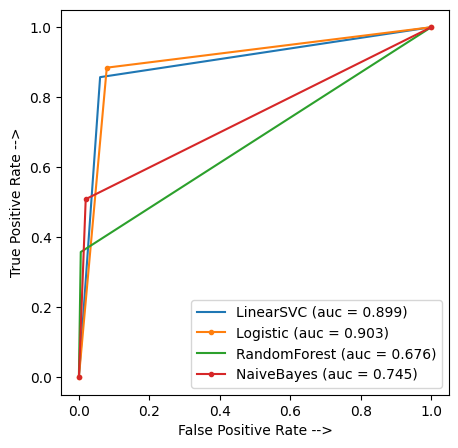

In [75]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(LinearSVC_fpr , LinearSVC_tpr, linestyle='-', label='LinearSVC (auc = %0.3f)' % auc_linearsvc)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(rf_fpr , rf_tpr, linestyle='-', label='RandomForest (auc = %0.3f)' % auc_rf)
plt.plot(nb_fpr , nb_tpr, marker='.', label='NaiveBayes (auc = %0.3f)' % auc_nb)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()


### Precision Recall Curve

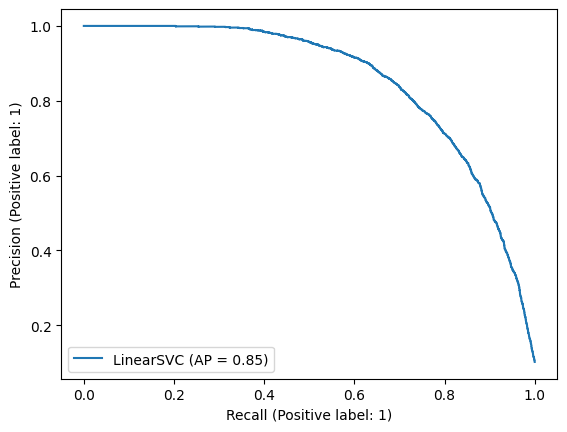

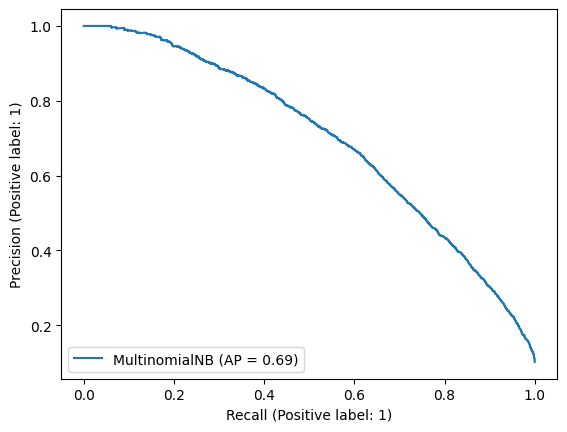

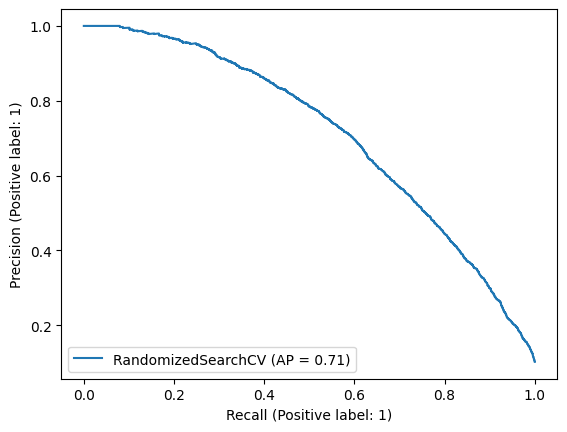

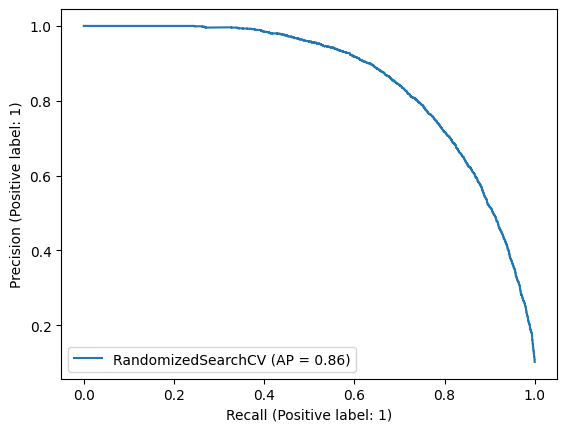

In [76]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(lsvc_model,norm_test_w2v5,y_test_w2v5)
plot_precision_recall_curve(nb_model,norm_test_w2v5,y_test_w2v5)
plot_precision_recall_curve(rf_RandomGrid,norm_test_w2v4,y_test_w2v4)
plot_precision_recall_curve(final_model,norm_test_w2v2,y_test_w2v2)

## **12. Finding Optimal Threshold For Binary Classification**

In [79]:
n_list = []
from sklearn.metrics import accuracy_score
for model in [nb_model,final_model,rf_RandomGrid]:
    n_list.append(pd.Series(model.predict_proba(norm_test_w2v4)[:,1]))
final_prediction  = pd.concat(n_list,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test_w2v4,final_prediction)))
# print('Ensemble test Accuracy: {}'.format(accuracy_score(y_test_w2v5,final_prediction)))

Ensemble test roc-auc: 0.9619029277964721


13. Finding Results For Expected Best Model We finded during analysis

## OTHER DATASETS

In [92]:
dataset2 = pd.read_csv("train_E6oV3lV.csv")
Counter(dataset2["label"])
dataset2["tweet"] = apply_regex(dataset2["tweet"])
dataset2["tokenized"] = dataset2["tweet"].apply(tokenize)
dataset2['stemmed'] = dataset2['tokenized'].apply(applyStemming)
other_test = dataset2["stemmed"]
ans_test = dataset2["label"]
other_test_w2v = embedding_feats(other_test, wordVec)


In [93]:
p_1 = rf_RandomGrid.predict(other_test_w2v)
make_classification_score(ans_test,p_1,"randomforest_tuned_w2v")


,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,randomforest_tuned_w2v,0.756805,0.136621,0.274309,0.090963,0.793203,615,23574,6146,1627,31962


*Better Than Machine*